<a href="https://colab.research.google.com/github/riti1302/Cartoon-Emotion-Recognition/blob/master/Cartoon_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q cython pyyaml==5.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 276kB 7.0MB/s 


In [0]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 3862 (delta 8), reused 12 (delta 8), pack-reused 3827
Receiving objects: 100% (3862/3862), 2.24 MiB | 4.27 MiB/s, done.
Resolving deltas: 100% (2667/2667), done.


In [0]:
!rm -rf 'detectron2_repo' 

In [0]:
!pip install -q -U watermark

In [0]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

CPython 3.6.9
IPython 5.5.0

numpy 1.18.2
pandas 1.0.3
pycocotools 2.0
torch 1.4.0
torchvision 0.5.0
detectron2 0.1.1


In [0]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('Train_annotated.csv')
df.head()

,Frame_ID,Emotion,width,height,x_min,y_min,x_max,y_max,class_name
0,frame0.jpg,happy,1280,720,543,197,747,389,face
1,frame1.jpg,happy,1280,720,839,430,1005,574,face
2,frame2.jpg,surprised,1280,720,733,67,929,311,face
3,frame3.jpg,surprised,1280,720,743,308,933,451,face
4,frame4.jpg,angry,1280,720,477,104,670,262,face


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def annotate_image(annotations, resize=True):
  file_name = annotations.Frame_ID.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'/content/drive/My Drive/train_frames/{file_name}'), cv2.COLOR_BGR2RGB)

  for i, a in annotations.iterrows():    
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)

  if not resize:
    return img

  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

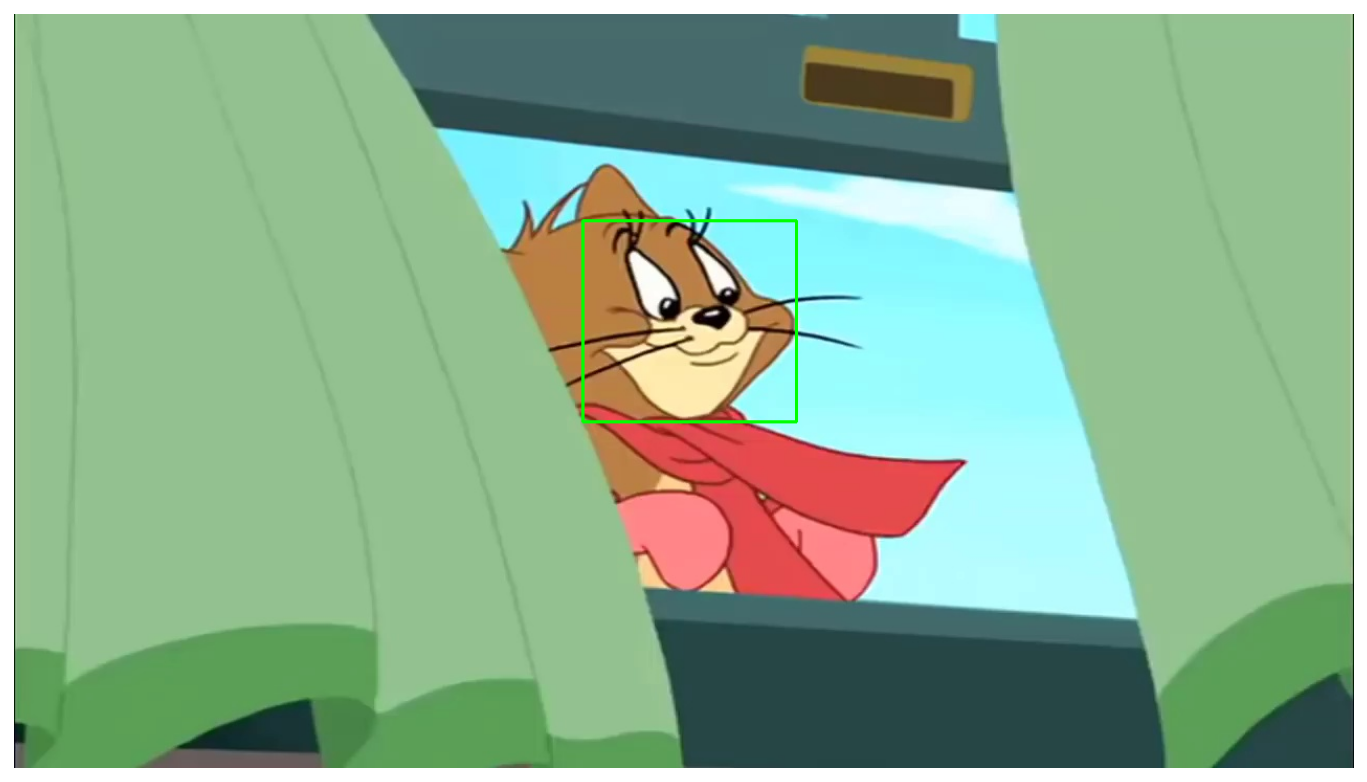

In [0]:
img_df = df[df.Frame_ID == df.Frame_ID.unique()[0]]
#print(img_df)
img = annotate_image(img_df, resize=False)

plt.imshow(img)
plt.axis('off');

In [0]:
sample_images = [annotate_image(df[df.Frame_ID == f]) for f in df.Frame_ID.unique()[:10]]
sample_images = torch.as_tensor(sample_images)
sample_images.shape

torch.Size([10, 384, 384, 3])

In [0]:
sample_images = sample_images.permute(0, 3, 1, 2)
sample_images.shape

torch.Size([10, 3, 384, 384])

In [0]:
plt.figure(figsize=(24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow=5)
print(grid_img.shape)
plt.imshow(grid_img.permute(1, 2, 0))

plt.axis('off');

In [0]:
TRAIN_IMAGES_PATH = f'/content/drive/My Drive/train_frames'

unique_files = df.Frame_ID.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.95), replace=False))
train_df = df[df.Frame_ID.isin(train_files)]
val_df = df[~df.Frame_ID.isin(train_files)]

train_df.head()

,Frame_ID,Emotion,width,height,x_min,y_min,x_max,y_max,class_name
0,frame0.jpg,happy,1280,720,543,197,747,389,face
1,frame1.jpg,happy,1280,720,839,430,1005,574,face
2,frame2.jpg,surprised,1280,720,733,67,929,311,face
3,frame3.jpg,surprised,1280,720,743,308,933,451,face
4,frame4.jpg,angry,1280,720,477,104,670,262,face


In [0]:
classes = df.class_name.unique().tolist()
classes

['face']

In [0]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.Frame_ID.unique()):

    record = {}

    image_df = df[df.Frame_ID == img_name]         # to get the row of dataframe corresponding to the same frame names

    file_path = f'{TRAIN_IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [0]:
for d in ["train", "val"]:
  DatasetCatalog.register("faces_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else val_df, classes))
  MetadataCatalog.get("faces_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("faces_train")

In [0]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [0]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [0]:
cfg.DATASETS.TRAIN = ("faces_train",)
cfg.DATASETS.TEST = ("faces_val",)
cfg.DATALOADER.NUM_WORKERS = 4

In [0]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [0]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500

In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/15 02:32:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:37, 11.5MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[04/15 02:32:51 d2.engine.train_loop]: Starting training from iteration 0
[04/15 02:33:55 d2.utils.events]:  eta: 1:19:19  iter: 19  total_loss: 1.816  loss_cls: 0.538  loss_box_reg: 0.518  loss_mask: 0.691  loss_rpn_cls: 0.067  loss_rpn_loc: 0.007  time: 3.1906  data_time: 0.0831  lr: 0.000020  max_mem: 10891M
[04/15 02:35:03 d2.utils.events]:  eta: 1:20:08  iter: 39  total_loss: 1.865  loss_cls: 0.486  loss_box_reg: 0.589  loss_mask: 0.671  loss_rpn_cls: 0.068  loss_rpn_loc: 0.008  time: 3.3141  data_time: 0.0112  lr: 0.000040  max_mem: 10891M
[04/15 02:36:19 d2.utils.events]:  eta: 1:22:02  iter: 59  total_loss: 1.861  loss_cls: 0.446  loss_box_reg: 0.724  loss_mask: 0.640  loss_rpn_cls: 0.031  loss_rpn_loc: 0.008  time: 3.4710  data_time: 0.0102  lr: 0.000060  max_mem: 10891M
[04/15 02:37:34 d2.utils.events]:  eta: 1:26:05  iter: 79  total_loss: 1.863  loss_cls: 0.434  loss_box_reg: 0.809  loss_mask: 0.590  loss_rpn_cls: 0.021  loss_rpn_loc: 0.008  time: 3.5435  data_time: 0.0105  

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

In [0]:
evaluator = COCOEvaluator("faces_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "faces_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/15 04:15:24 d2.data.common]: Serializing 9 elements to byte tensors and concatenating them all ...
[04/15 04:15:24 d2.data.common]: Serialized dataset takes 0.00 MiB
[04/15 04:15:24 d2.evaluation.evaluator]: Start inference on 9 images
[04/15 04:15:27 d2.evaluation.evaluator]: Total inference time: 0:00:01.262223 (0.315556 s / img per device, on 1 devices)
[04/15 04:15:27 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.277947 s / img per device, on 1 devices)
[04/15 04:15:27 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/15 04:15:27 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/15 04:15:27 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=

OrderedDict([('bbox',
              {'AP': 73.98739873987398,
               'AP50': 100.0,
               'AP75': 100.0,
               'APl': 76.35077793493635,
               'APm': 65.54455445544555,
               'APs': nan}),
             ('segm',
              {'AP': 72.29122912291228,
               'AP50': 100.0,
               'AP75': 100.0,
               'APl': 75.42668552569543,
               'APm': 61.12211221122112,
               'APs': nan})])

In [0]:
TEST_IMAGES_PATH = f'/content/drive/My Drive/test_frames'
test_df = pd.read_csv('Test.csv')

In [0]:
os.makedirs("annotated_results", exist_ok=True)

test_image_paths = test_df.Frame_ID.to_numpy()
test_image_paths

In [0]:
faces = pd.DataFrame(columns = ['Frame_ID','x_min', 'y_min', 'x_max', 'y_max', 'score'])
for clothing_image in test_image_paths:
  file_path = f'{TEST_IMAGES_PATH}/{clothing_image}'
  if not os.path.isfile(file_path):
    continue
  im = cv2.imread(file_path)
  width, height = im.shape[:2]
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata, 
    scale=1., 
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  boxes = instances.pred_boxes.tensor.numpy() if instances.has("pred_boxes") else [[0, 0, 0, 0]]
  scores = instances.scores.numpy() if instances.has("scores") else [0.1]
  for bbox, score in zip(boxes, scores):
    faces.loc[len(faces)]=[clothing_image, bbox[0], bbox[1], bbox[2], bbox[3], score]
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)
  #print(faces)
faces.to_csv('Test_annotated.csv', header=True, index=None)

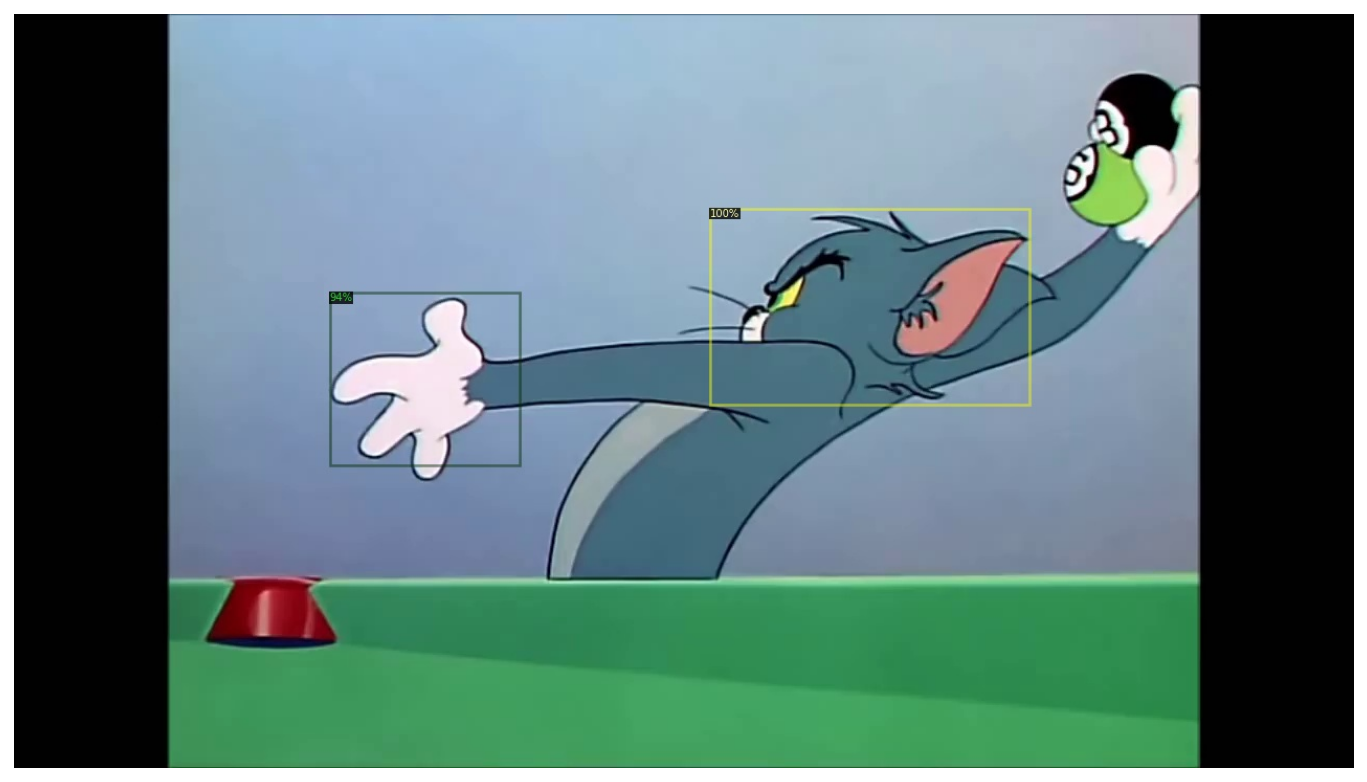

In [0]:
annotated_images = [f'annotated_results/{f}' for f in test_df.Frame_ID.unique()]
img = cv2.cvtColor(cv2.imread(annotated_images[0]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

In [0]:
!zip -r annotated_results.zip annotated_results

  adding: annotated_results/ (stored 0%)
  adding: annotated_results/test118.jpg (deflated 6%)
  adding: annotated_results/test171.jpg (deflated 6%)
  adding: annotated_results/test96.jpg (deflated 5%)
  adding: annotated_results/test26.jpg (deflated 8%)
  adding: annotated_results/test67.jpg (deflated 3%)
  adding: annotated_results/test129.jpg (deflated 8%)
  adding: annotated_results/test89.jpg (deflated 4%)
  adding: annotated_results/test31.jpg (deflated 4%)
  adding: annotated_results/test158.jpg (deflated 7%)
  adding: annotated_results/test24.jpg (deflated 9%)
  adding: annotated_results/test19.jpg (deflated 8%)
  adding: annotated_results/test154.jpg (deflated 4%)
  adding: annotated_results/test136.jpg (deflated 5%)
  adding: annotated_results/test28.jpg (deflated 5%)
  adding: annotated_results/test142.jpg (deflated 11%)
  adding: annotated_results/test56.jpg (deflated 6%)
  adding: annotated_results/test148.jpg (deflated 4%)
  adding: annotated_results/test12.jpg (deflated 